In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def translation_speed(u_l,u_r,R_l=1,R_r=1):
  return((R_r*u_r+R_l*u_l)/2)

def wheel_speed(u_l,u_r,R_l=1,R_r=1,wheel_base=1):
  return((R_r*u_r-R_l*u_l)/(2*wheel_base))

def get_process(x,y,angle, T, u_l,u_r,R_l=1,R_r=1,wheel_base=1):
  f_matrix = np.array([
                       x+T*translation_speed(u_l,u_r,R_l,R_r)*np.cos(angle)-pow(T,2)*translation_speed(u_l,u_r,R_l,R_r)*wheel_speed(u_l,u_r,R_l,R_r,wheel_base)*np.sin(angle),
                       y+T*translation_speed(u_l,u_r,R_l,R_r)*np.sin(angle)+pow(T,2)*translation_speed(u_l,u_r,R_l,R_r)*wheel_speed(u_l,u_r,R_l,R_r,wheel_base)*np.cos(angle),
                       angle+T*wheel_speed(u_l,u_r,R_l,R_r,wheel_base)
  ])
  return(f_matrix)

def get_process_Jac(angle, T, u_l,u_r,R_l=1,R_r=1,wheel_base=1):
  f_matrix = np.array([
          [1,0, -T*translation_speed(u_l,u_r,R_l,R_r)*np.sin(angle)-pow(T,2)*translation_speed(u_l,u_r,R_l,R_r)*wheel_speed(u_l,u_r,R_l,R_r,wheel_base)*np.cos(angle)],
          [0,1, T*translation_speed(u_l,u_r,R_l,R_r)*np.cos(angle)-pow(T,2)*translation_speed(u_l,u_r,R_l,R_r)*wheel_speed(u_l,u_r,R_l,R_r,wheel_base)*np.sin(angle)],
          [0,0,1]
  ])
  return(f_matrix)

def get_obs(x,y,angle):
  return(np.array([x,y,angle]))

def ekf(obs, state_prev, P, H, R, T):
    #Прогноз
    m_pred = get_process(state_prev[0], state_prev[1], state_prev[2], T, state_prev[3], state_prev[4])
    F = get_process_Jac(state_prev[2], T, state_prev[3], state_prev[4])
    P_pred = F @ P @ F.T
    #Коррекция
    S = H @ P_pred @ H.T + R
    K = P_pred @  H.T @  np.linalg.inv(S)
    m_current = m_pred + K @ (obs[:3] - get_obs(m_pred[0], m_pred[1], m_pred[2]))
    P_current = P_pred - K @ S @ K.T

    return(np.hstack((m_current,obs[3:])), P_current)

In [ ]:
#Сonstants
T = 1

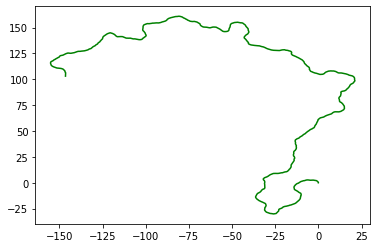

In [ ]:
from numpy.random import normal, uniform
sample = np.array([[0,0,0,0,0]])

for i in range(1,1200):
  right_anve = abs(normal(0,0.5))
  left_anve = abs(normal(0,0.5))
  sample = np.vstack([sample,[
    sample[i-1][0]-T*translation_speed(left_anve,right_anve)*np.sin(sample[i-1][2])-pow(T,2)*translation_speed(left_anve,right_anve,)*wheel_speed(left_anve,right_anve)*np.cos(sample[i-1][2]),
    sample[i-1][1]+T*translation_speed(left_anve,right_anve)*np.cos(sample[i-1][2])-pow(T,2)*translation_speed(left_anve,right_anve,)*wheel_speed(left_anve,right_anve)*np.sin(sample[i-1][2]),
    sample[i-1][2]+wheel_speed(left_anve,right_anve),
    left_anve,
    right_anve
]])

sample_noize = np.array([[0,0,0,0,0]])
for element in sample[1:]:

  sample_noize = np.vstack([sample_noize,
                       [element[0]+normal(0,1),
                        element[1]+normal(0,1),
                        element[2]+normal(0,0.5),
                        element[3],
                        element[4]]
])
plt.plot(sample[:,0],sample[:,1], color = 'green')

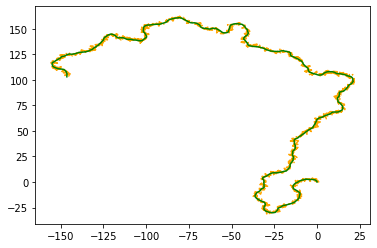

In [ ]:
plt.plot(sample_noize[:,0],sample_noize[:,1],'-.' ,color = 'orange')
plt.plot(sample[:,0],sample[:,1], color = 'green')

In [ ]:
var_arr = np.var((sample-sample_noize)[:,:3], axis =  0)

In [ ]:
var_arr

array([0.99756551, 0.98858661, 0.25439682])

In [ ]:
sample_efk = np.array([sample[0]])

#Predefined values
H = np.array([
            [1,0,0],
            [0,1,0],
            [0,0,1]
], dtype = np.float32)

R = np.array([
            [var_arr[0],0,0],
            [0,var_arr[1],0],
            [0,0,var_arr[2]]
], dtype = np.float32)

P = np.array([
            [0.1,0,0],
            [0,0.1,0],
            [0,0,0.1]
], dtype = np.float32)

for element in sample_noize[1:]:
  row, P = ekf(element,sample_efk[-1] ,P,H,R,T)
  sample_efk = np.vstack([sample_efk, row])

In [ ]:
%matplotlib inline

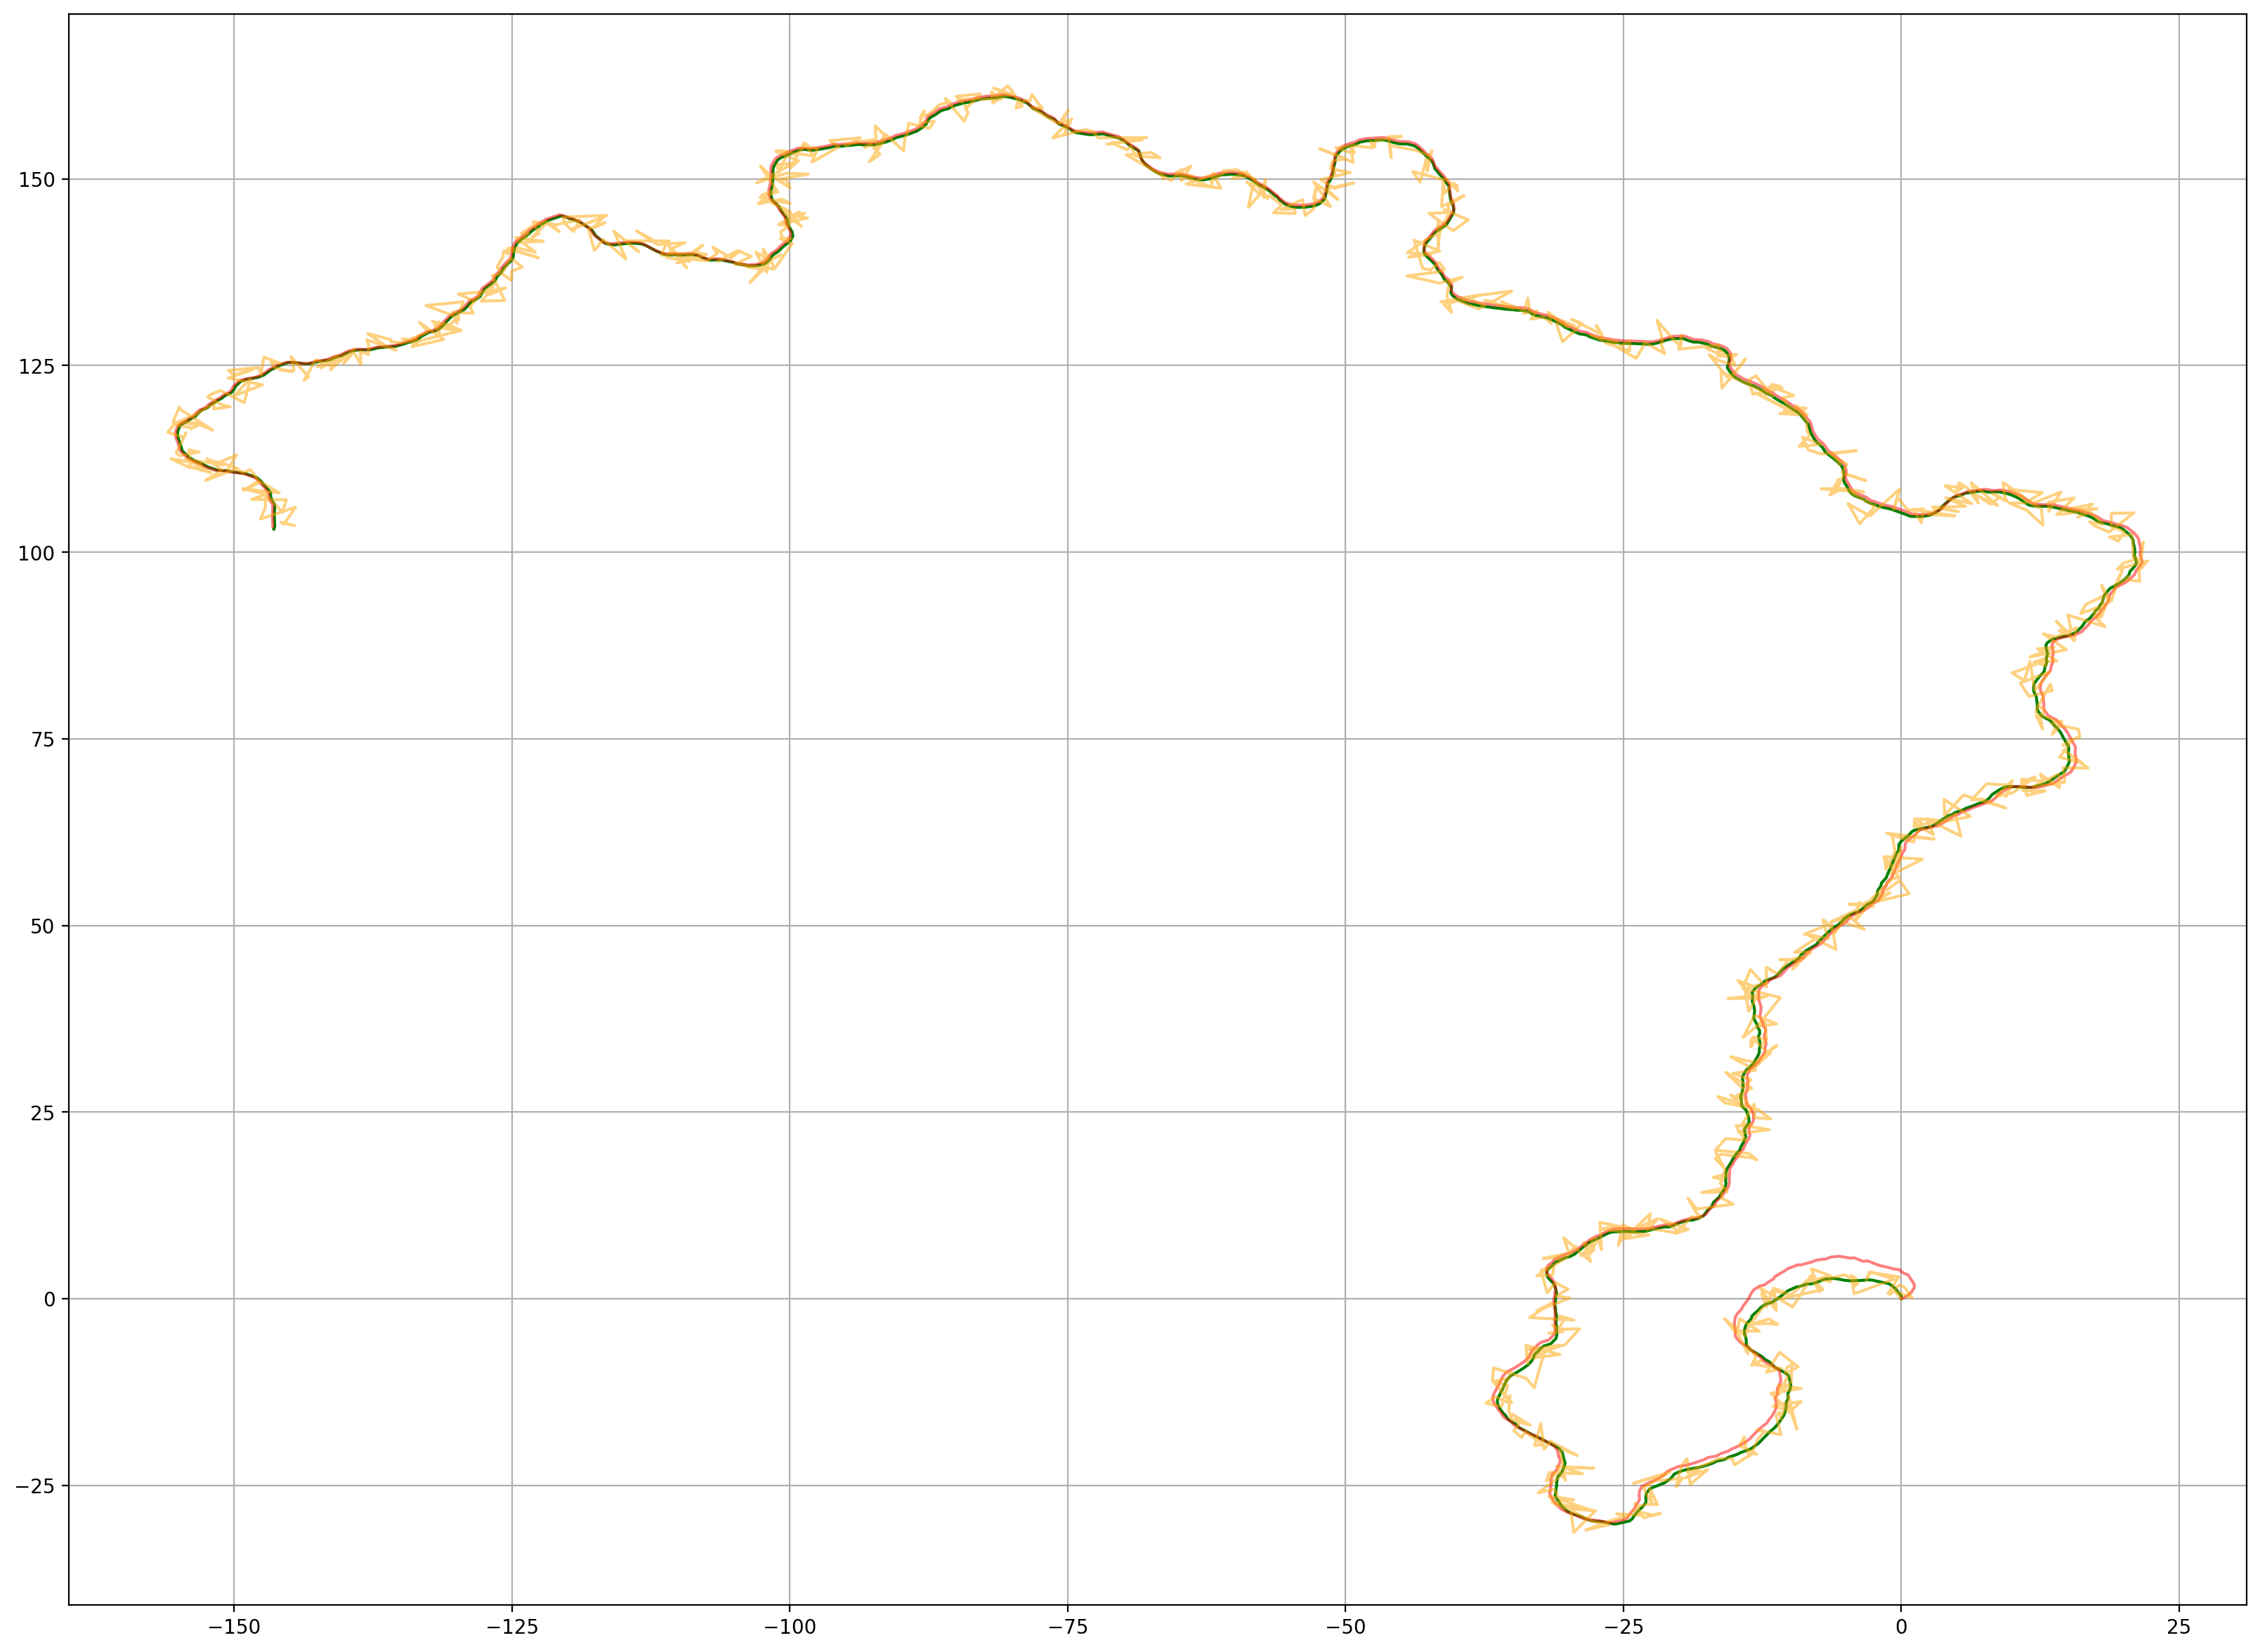

In [ ]:
plt.figure(figsize=(20, 15), dpi=200)
plt.plot(sample[:,0],sample[:,1], color = 'green')
plt.plot(sample_efk[:,0],sample_efk[:,1], color = 'red', alpha = 0.5)
plt.plot(sample_noize[:,0],sample_noize[:,1],'-' ,color = 'orange', alpha = 0.5)
plt.grid(True)

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
(np.sum((sample[501:,:3]-sample_efk[501:,:3])**2, axis = 0))/len(sample[501:])

array([0.1537325 , 0.11302566, 2.49695172])

In [ ]:
(np.sum((sample[501:,:3]-sample_noize[501:,:3])**2, axis = 0))/len(sample[501:])

array([0.95717861, 0.95062117, 0.26172494])